In [31]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [18]:
# Download daily gold futures data for the last 3 months
data = yf.download("GC=F", period="3mo", interval="1d")
close_prices = data['Close']['GC=F']
close_prices.head()

/var/folders/q3/9v6_7yk17_3gzz626ngfv51h0000gn/T/ipykernel_7650/1864209210.py:2: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download("GC=F", period="3mo", interval="1d")
[*********************100%***********************]  1 of 1 completed


Date
2025-08-27    3404.600098
2025-08-28    3431.800049
2025-08-29    3473.699951
2025-09-02    3549.399902
2025-09-03    3593.199951
Name: GC=F, dtype: float64

In [17]:
returns = np.log(close_prices / close_prices.shift(1)).dropna()
mu = returns.mean()
sigma = returns.std()

pd.DataFrame({
    'Average daily return': [mu],
    'Daily volatility': [sigma]
})

,Average daily return,Daily volatility
0,0.003288,0.015213


In [19]:
S0 = close_prices.iloc[-1]  # last closing price
T = 5                        # simulate 5 days
steps_per_day = 24            # hourly steps
steps = T * steps_per_day
paths = 500                  # number of simulation paths

dt = 1 / steps_per_day
sigma_hourly = sigma / np.sqrt(steps_per_day)
mu_hourly = mu / steps_per_day

simulations = np.zeros((steps, paths))
simulations[0] = S0

In [35]:
for t in range(1, steps):
    Z = np.random.normal(size=paths)
    simulations[t] = simulations[t-1] * np.exp((mu_hourly - 0.5*sigma_hourly**2)*dt + sigma_hourly*np.sqrt(dt)*Z)

simulations.shape

(120, 500)

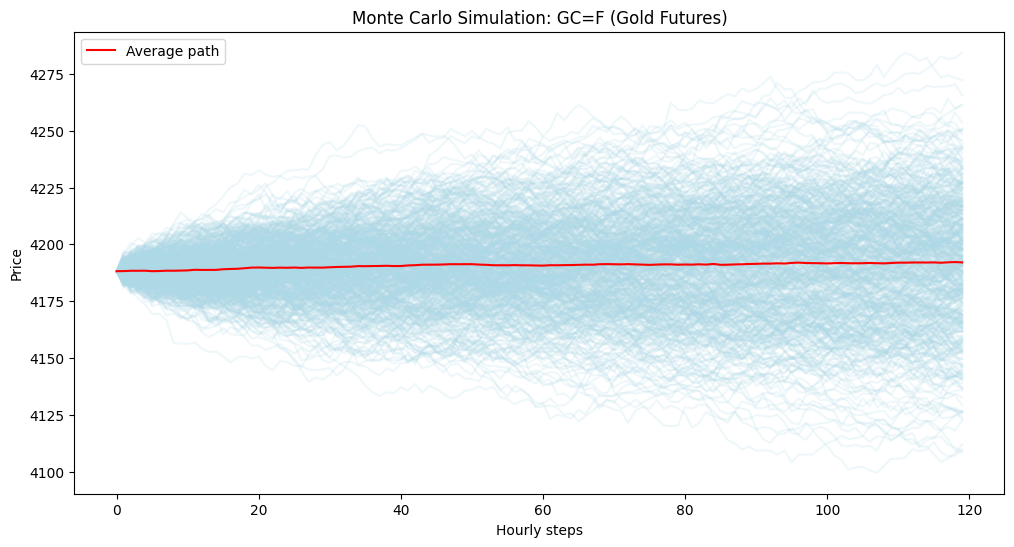

In [36]:
plt.figure(figsize=(12,6))
plt.plot(simulations, color='lightblue', alpha=0.2)  # all paths faint
plt.plot(simulations.mean(axis=1), color='red', label='Average path')  # mean path
plt.title("Monte Carlo Simulation: GC=F (Gold Futures)")
plt.xlabel("Hourly steps")
plt.ylabel("Price")
plt.legend()
plt.show()

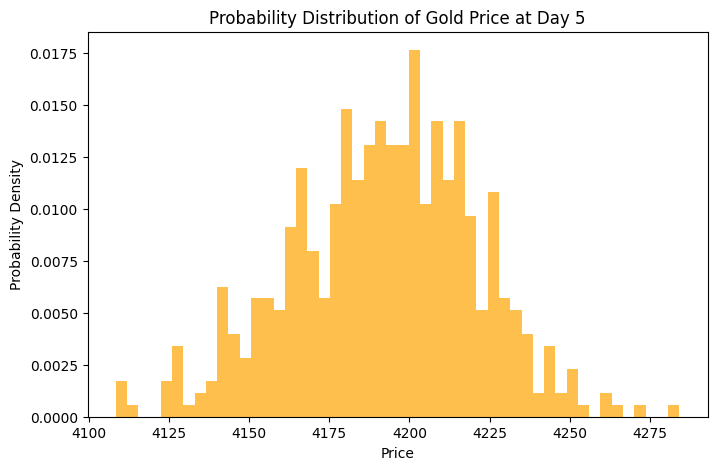

In [37]:
plt.figure(figsize=(8,5))
plt.hist(simulations[-1], bins=50, density=True, color='orange', alpha=0.7)
plt.title("Probability Distribution of Gold Price at Day 5")
plt.xlabel("Price")
plt.ylabel("Probability Density")
plt.show()

In [33]:
pd.Series(simulations[-1]).describe()

count     500.000000
mean     4190.559108
std        27.447462
min      4115.801561
25%      4171.928385
50%      4190.419792
75%      4209.373074
max      4277.935100
dtype: float64

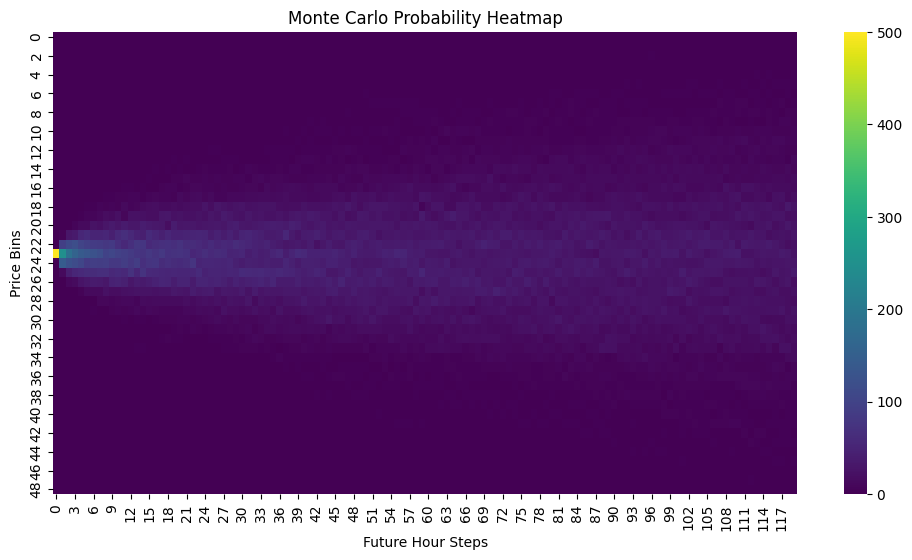

In [34]:
# Define price bins
bins = np.linspace(simulations.min(), simulations.max(), 50)

# Create histogram counts per time step
heatmap_data = np.zeros((len(bins)-1, steps))
for t in range(steps):
    counts, _ = np.histogram(simulations[t], bins=bins)
    heatmap_data[:, t] = counts

plt.figure(figsize=(12,6))
sns.heatmap(heatmap_data, cmap='viridis')
plt.xlabel("Future Hour Steps")
plt.ylabel("Price Bins")
plt.title("Monte Carlo Probability Heatmap")
plt.show()